# AI Music Generator
A Deep Learning Project to generate music using Recurrent Neural Networks
trained on Maestro dataset from Google.
## Installs

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

# Preparation

## Imports

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider
import ipywidgets as widgets

## Setting random

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000

## Preparing data

In [4]:
data_dir = pathlib.Path('data/maestro-v2_extracted/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Initializing functions

In [5]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    """
    Display a pretty_midi audio file to play
    :param pm: PrettyMIDI object
    :param seconds: number of seconds to display (default 30)
    :return: display audio file
    """
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    """
    Convert MIDI file to notes
    :param midi_file: name of the file to be converted
    :return: notes dataframe
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
        start = note.start
        end = note.end
        # Getting notes information: pitch, start, end, step and duration
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def plot_piano_roll(
        notes: pd.DataFrame,
        count: Optional[int] = None):
    """
    Plot a piano roll graph
    :param notes: notes to be displayed
    :param count: number of notes to be displayed
    """
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

def notes_to_midi(
        notes: pd.DataFrame,
        out_file: str,
        instrument_name: str,
        velocity: int = 100,
) -> pretty_midi.PrettyMIDI:
    """
    Convert notes to MIDI file
    :param notes: notes to be converted
    :param out_file: name of the result file
    :param instrument_name: playing instrument
    :param velocity: velocity of the notes (volume)
    :return: pretty_midi object
    """
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

def create_sequences(
        dataset: tf.data.Dataset,
        seq_length: int,
        vocab_size = 128,
) -> tf.data.Dataset:
    """
    Create a dataset of sequences of notes
    :param dataset: dataset to be created
    :param seq_length: length of the sequence
    :param vocab_size: size of the vocabulary
    :return: dataset of sequences of notes
    """
    seq_length = seq_length+1
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    Calculate the MSE with positive pressure
    :param y_true: true values
    :param y_pred: predicted values
    :return: mean squared error
    """
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

def predict_next_note(
        notes: np.ndarray,
        keras_model: tf.keras.Model,
        temperature: float = 1.0
) -> tuple[int, float, float]:
    """
    Predict next note
    :param notes: previous notes
    :param keras_model: model
    :param temperature: temperature of the model
    :return: next note values (pitch, step, duration)
    """
    assert temperature > 0

    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

# Creating dataset

In [6]:
num_files = 5 # Change this number of files to affect the training (high impact on time)
all_notes = []
for i in tqdm(range(num_files)):
    f = filenames[i]
    notes = midi_to_notes(f)
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
batch_size = 64
buffer_size = n_notes - seq_length
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


# Model

## Creating model

In [7]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

## Training model

In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [9]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - duration_loss: 0.0914 - loss: 0.3421 - pitch_loss: 4.3048 - step_loss: 0.0355
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


377/377 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - duration_loss: 0.0780 - loss: 0.3082 - pitch_loss: 3.9556 - step_loss: 0.0324
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - duration_loss: 0.0767 - loss: 0.3057 - pitch_loss: 3.9393 - step_loss: 0.0320
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - duration_loss: 0.0761 - loss: 0.3035 - pitch_loss: 3.9219 - step_loss: 0.0313
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - duration_loss: 0.0757 - loss: 0.2996 - pitch_loss: 3.8836 - step_loss: 0.0297
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - duration_loss: 0.0740 - loss: 0.2963 - pitch_loss: 3.8608 - step_loss: 0.0292
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - duration_loss: 0.0725 - loss: 0.2959 - pitch_loss: 3.8717 - step_loss: 0.0298
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - duration_loss: 0.0737 - loss: 0.2945 - pitch_loss: 3.8450 - step_loss: 0.0285
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - duration_loss: 0.

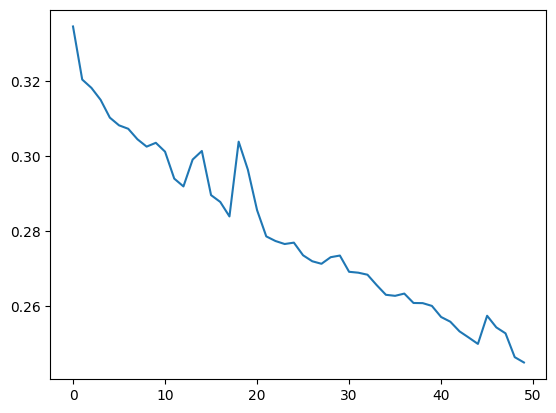

In [10]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generating Songs

In [ ]:
temperature = 1.0
num_predictions = 300
tempo = 1.0
glob_pitch = 1.0
glob_velocity = 100
@interact(
    temperature_inter = FloatSlider(min=0.0, max=500.0, step=1.0, value=100.0),
    num_predictions_inter = IntSlider(min=25, max=1000, step=1, value=300),
    tempo_inter = FloatSlider(min=0.1, max=2.0, step=0.05, value=1.0),
    pitch_inter = FloatSlider(min=0.0, max=127.0, step=1.0, value=100.0),
    velocity_inter = IntSlider(min=0, max=127, step=1, value = 100)
)
def save_generator_meta(temperature_inter, num_predictions_inter, tempo_inter, pitch_inter, velocity_inter):
    global temperature, num_predictions, tempo, glob_pitch, glob_velocity
    temperature = temperature_inter / 100
    num_predictions = num_predictions_inter
    tempo = tempo_inter
    glob_pitch = pitch_inter / 100
    glob_velocity = velocity_inter

In [16]:
# At first, take sample file to base new track on it
sample_file = filenames[1]
raw_notes = midi_to_notes(sample_file)
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
pm = pretty_midi.PrettyMIDI(sample_file)
# Take instrument from this sample (if needed, you can choose your own)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    pitch *= glob_pitch
    step /= tempo
    duration /= tempo
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

In [17]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,54.0,0.047227,0.050926,0.047227,0.098153
1,95.0,0.195338,0.538039,0.242565,0.780605
2,88.0,0.194177,0.578585,0.436743,1.015328
3,86.0,0.202732,0.582778,0.639474,1.222252
4,89.0,0.211605,0.581767,0.851079,1.432846
5,94.0,0.220954,0.580741,1.072033,1.652775
6,86.0,0.231608,0.581580,1.303642,1.885222
7,87.0,0.242819,0.582952,1.546460,2.129412
8,78.0,0.251597,0.586258,1.798058,2.384316
9,88.0,0.255027,0.586609,2.053085,2.639693


In [18]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name, velocity=glob_velocity)
display_audio(out_pm)

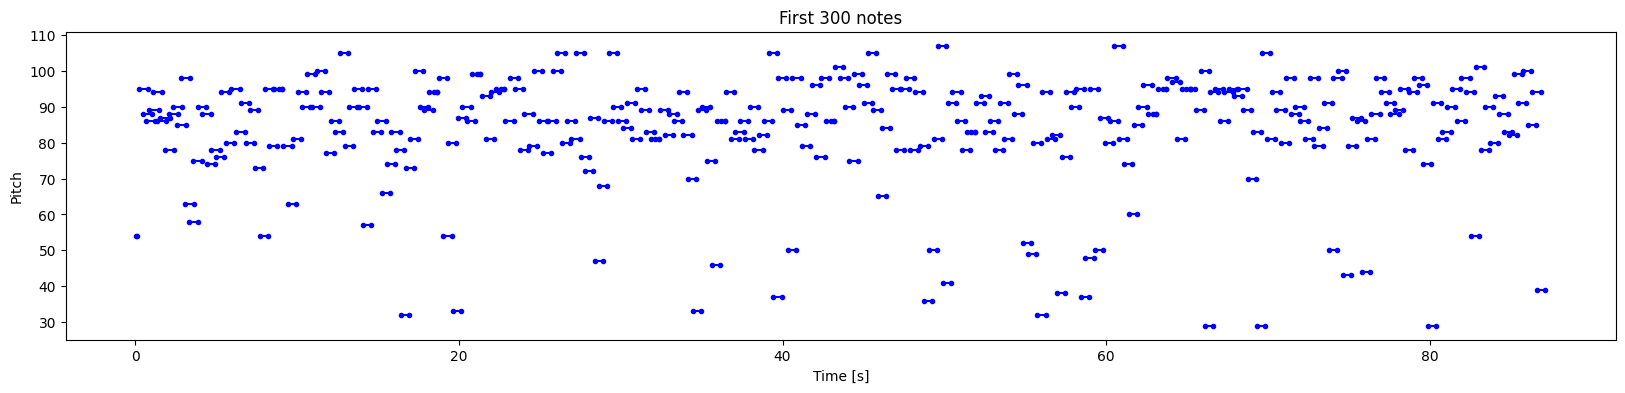

In [19]:
plot_piano_roll(midi_to_notes('output.mid'), count=num_predictions)